In [3]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/ANDL/Homework_1


In [4]:
!unzip atMost900.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: atMost900/train/Species4/00059.jpg  
  inflating: atMost900/train/Species4/00060.jpg  
  inflating: atMost900/train/Species4/00061.jpg  
  inflating: atMost900/train/Species4/00062.jpg  
  inflating: atMost900/train/Species4/00064.jpg  
  inflating: atMost900/train/Species4/00065.jpg  
  inflating: atMost900/train/Species4/00066.jpg  
  inflating: atMost900/train/Species4/00067.jpg  
  inflating: atMost900/train/Species4/00068.jpg  
  inflating: atMost900/train/Species4/00069.jpg  
  inflating: atMost900/train/Species4/00070.jpg  
  inflating: atMost900/train/Species4/00072.jpg  
  inflating: atMost900/train/Species4/00073.jpg  
  inflating: atMost900/train/Species4/00074.jpg  
  inflating: atMost900/train/Species4/00075.jpg  
  inflating: atMost900/train/Species4/00076.jpg  
  inflating: atMost900/train/Species4/00077.jpg  
  inflating: atMost900/train/Species4/00078.jpg  
  inflating: atMost900/train/Species4/00080.jpg  


In [5]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [6]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [7]:
# Dataset folders 
dataset_dir = 'atMost900'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

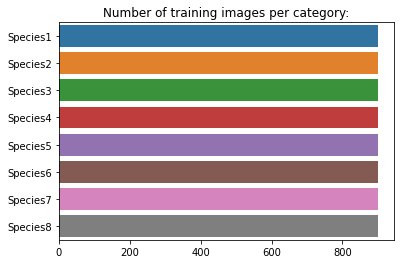

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [10]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 7200 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [11]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 1. 0. 0. 0. 0.]
Label: 3
Class name: Species4


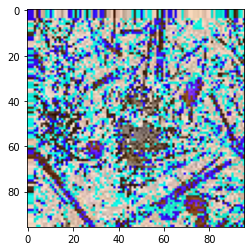

In [12]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [13]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

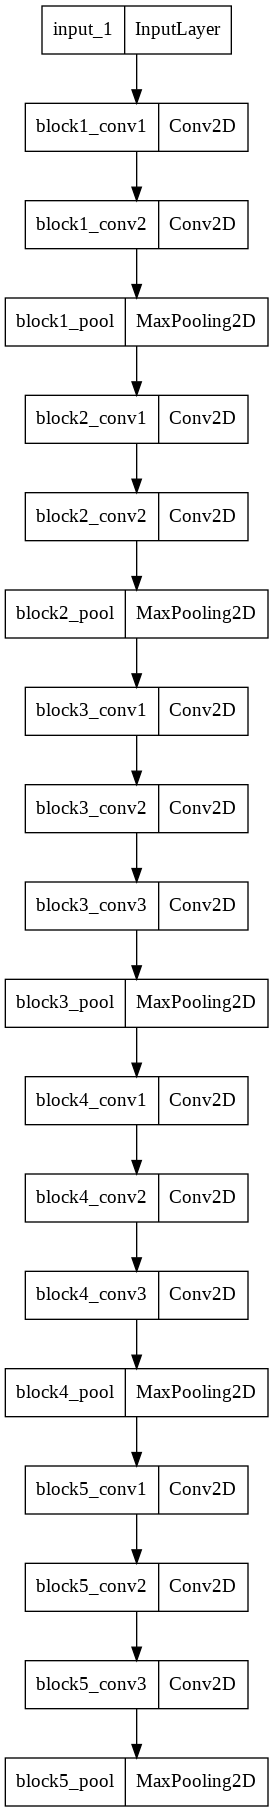

In [14]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [15]:
input_shape = (96, 96, 3)
epochs = 200

In [16]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [17]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [18]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
225/225 [==============================] - ETA: 0s - loss: 2.7096 - accuracy: 0.4219 - precision: 0.4943 - recall: 0.3139

225/225 [==============================] - 44s 161ms/step - loss: 2.7096 - accuracy: 0.4219 - precision: 0.4943 - recall: 0.3139 - val_loss: 1.2137 - val_accuracy: 0.5389 - val_precision: 0.7137 - val_recall: 0.3264
Epoch 2/200
225/225 [==============================] - ETA: 0s - loss: 1.2787 - accuracy: 0.5357 - precision: 0.6688 - recall: 0.3890

225/225 [==============================] - 34s 152ms/step - loss: 1.2787 - accuracy: 0.5357 - precision: 0.6688 - recall: 0.3890 - val_loss: 1.1648 - val_accuracy: 0.5560 - val_precision: 0.6812 - val_recall: 0.3852
Epoch 3/200
225/225 [==============================] - ETA: 0s - loss: 1.1465 - accuracy: 0.5792 - precision: 0.7053 - recall: 0.4425

225/225 [==============================] - 35s 157ms/step - loss: 1.1465 - accuracy: 0.5792 - precision: 0.7053 - recall: 0.4425 - val_loss: 1.0634 - val_accuracy: 0.6357 - val_precision: 0.8055 - val_recall: 0.4478
Epoch 4/200
225/225 [==============================] - ETA: 0s - loss: 1.0505 - accuracy: 0.6228 - precision: 0.7367 - recall: 0.4971

225/225 [==============================] - 35s 157ms/step - loss: 1.0505 - accuracy: 0.6228 - precision: 0.7367 - recall: 0.4971 - val_loss: 1.0141 - val_accuracy: 0.6224 - val_precision: 0.7680 - val_recall: 0.4459
Epoch 5/200
225/225 [==============================] - ETA: 0s - loss: 0.9670 - accuracy: 0.6432 - precision: 0.7579 - recall: 0.5290

225/225 [==============================] - 34s 152ms/step - loss: 0.9670 - accuracy: 0.6432 - precision: 0.7579 - recall: 0.5290 - val_loss: 1.0616 - val_accuracy: 0.5920 - val_precision: 0.7056 - val_recall: 0.4820
Epoch 6/200
225/225 [==============================] - ETA: 0s - loss: 0.9269 - accuracy: 0.6661 - precision: 0.7653 - recall: 0.5576

225/225 [==============================] - 36s 159ms/step - loss: 0.9269 - accuracy: 0.6661 - precision: 0.7653 - recall: 0.5576 - val_loss: 0.9891 - val_accuracy: 0.6452 - val_precision: 0.7629 - val_recall: 0.5313
Epoch 7/200
225/225 [==============================] - ETA: 0s - loss: 0.9021 - accuracy: 0.6736 - precision: 0.7720 - recall: 0.5756

225/225 [==============================] - 34s 151ms/step - loss: 0.9021 - accuracy: 0.6736 - precision: 0.7720 - recall: 0.5756 - val_loss: 1.0353 - val_accuracy: 0.6357 - val_precision: 0.7465 - val_recall: 0.5085
Epoch 8/200
225/225 [==============================] - ETA: 0s - loss: 0.8919 - accuracy: 0.6764 - precision: 0.7751 - recall: 0.5768

225/225 [==============================] - 35s 155ms/step - loss: 0.8919 - accuracy: 0.6764 - precision: 0.7751 - recall: 0.5768 - val_loss: 0.9988 - val_accuracy: 0.6395 - val_precision: 0.7752 - val_recall: 0.5104
Epoch 9/200
225/225 [==============================] - ETA: 0s - loss: 0.8518 - accuracy: 0.6875 - precision: 0.7827 - recall: 0.5962

225/225 [==============================] - 35s 156ms/step - loss: 0.8518 - accuracy: 0.6875 - precision: 0.7827 - recall: 0.5962 - val_loss: 0.9555 - val_accuracy: 0.6414 - val_precision: 0.7675 - val_recall: 0.5199
Epoch 10/200
225/225 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.7024 - precision: 0.7916 - recall: 0.6144

225/225 [==============================] - 34s 151ms/step - loss: 0.8212 - accuracy: 0.7024 - precision: 0.7916 - recall: 0.6144 - val_loss: 1.0109 - val_accuracy: 0.6224 - val_precision: 0.7397 - val_recall: 0.5123
Epoch 11/200
225/225 [==============================] - ETA: 0s - loss: 0.7977 - accuracy: 0.7093 - precision: 0.7984 - recall: 0.6278

225/225 [==============================] - 35s 155ms/step - loss: 0.7977 - accuracy: 0.7093 - precision: 0.7984 - recall: 0.6278 - val_loss: 1.0023 - val_accuracy: 0.6471 - val_precision: 0.7397 - val_recall: 0.5769
Epoch 12/200
225/225 [==============================] - ETA: 0s - loss: 0.7791 - accuracy: 0.7196 - precision: 0.8061 - recall: 0.6361

225/225 [==============================] - 34s 150ms/step - loss: 0.7791 - accuracy: 0.7196 - precision: 0.8061 - recall: 0.6361 - val_loss: 1.0373 - val_accuracy: 0.6262 - val_precision: 0.7371 - val_recall: 0.5161
Epoch 13/200
225/225 [==============================] - ETA: 0s - loss: 0.7606 - accuracy: 0.7299 - precision: 0.8077 - recall: 0.6474

225/225 [==============================] - 35s 155ms/step - loss: 0.7606 - accuracy: 0.7299 - precision: 0.8077 - recall: 0.6474 - val_loss: 1.0831 - val_accuracy: 0.6224 - val_precision: 0.7154 - val_recall: 0.5199
Epoch 14/200
225/225 [==============================] - ETA: 0s - loss: 0.7726 - accuracy: 0.7318 - precision: 0.8139 - recall: 0.6492

225/225 [==============================] - 35s 154ms/step - loss: 0.7726 - accuracy: 0.7318 - precision: 0.8139 - recall: 0.6492 - val_loss: 0.9820 - val_accuracy: 0.6395 - val_precision: 0.7431 - val_recall: 0.5598
Epoch 15/200
225/225 [==============================] - ETA: 0s - loss: 0.7758 - accuracy: 0.7251 - precision: 0.7995 - recall: 0.6410

225/225 [==============================] - 34s 150ms/step - loss: 0.7758 - accuracy: 0.7251 - precision: 0.7995 - recall: 0.6410 - val_loss: 1.0029 - val_accuracy: 0.6319 - val_precision: 0.7568 - val_recall: 0.5313
Epoch 16/200
225/225 [==============================] - ETA: 0s - loss: 0.7207 - accuracy: 0.7396 - precision: 0.8193 - recall: 0.6639

225/225 [==============================] - 35s 154ms/step - loss: 0.7207 - accuracy: 0.7396 - precision: 0.8193 - recall: 0.6639 - val_loss: 0.9717 - val_accuracy: 0.6490 - val_precision: 0.7451 - val_recall: 0.5769
Epoch 17/200
225/225 [==============================] - ETA: 0s - loss: 0.7220 - accuracy: 0.7411 - precision: 0.8191 - recall: 0.6749

225/225 [==============================] - 34s 153ms/step - loss: 0.7220 - accuracy: 0.7411 - precision: 0.8191 - recall: 0.6749 - val_loss: 1.0007 - val_accuracy: 0.6224 - val_precision: 0.7160 - val_recall: 0.5503
Epoch 18/200
225/225 [==============================] - ETA: 0s - loss: 0.7260 - accuracy: 0.7379 - precision: 0.8132 - recall: 0.6658

225/225 [==============================] - 35s 154ms/step - loss: 0.7260 - accuracy: 0.7379 - precision: 0.8132 - recall: 0.6658 - val_loss: 1.0119 - val_accuracy: 0.6490 - val_precision: 0.7190 - val_recall: 0.5731
Epoch 19/200
225/225 [==============================] - ETA: 0s - loss: 0.7045 - accuracy: 0.7496 - precision: 0.8199 - recall: 0.6772

225/225 [==============================] - 35s 155ms/step - loss: 0.7045 - accuracy: 0.7496 - precision: 0.8199 - recall: 0.6772 - val_loss: 1.0254 - val_accuracy: 0.6281 - val_precision: 0.7315 - val_recall: 0.5636
Epoch 20/200
225/225 [==============================] - ETA: 0s - loss: 0.7124 - accuracy: 0.7483 - precision: 0.8251 - recall: 0.6775

225/225 [==============================] - 33s 149ms/step - loss: 0.7124 - accuracy: 0.7483 - precision: 0.8251 - recall: 0.6775 - val_loss: 0.9456 - val_accuracy: 0.6698 - val_precision: 0.7647 - val_recall: 0.5920
Epoch 21/200
225/225 [==============================] - ETA: 0s - loss: 0.6448 - accuracy: 0.7640 - precision: 0.8304 - recall: 0.6986

225/225 [==============================] - 35s 154ms/step - loss: 0.6448 - accuracy: 0.7640 - precision: 0.8304 - recall: 0.6986 - val_loss: 0.9813 - val_accuracy: 0.6584 - val_precision: 0.7284 - val_recall: 0.5598
Epoch 22/200
225/225 [==============================] - ETA: 0s - loss: 0.6625 - accuracy: 0.7618 - precision: 0.8357 - recall: 0.6989

225/225 [==============================] - 34s 153ms/step - loss: 0.6625 - accuracy: 0.7618 - precision: 0.8357 - recall: 0.6989 - val_loss: 1.0511 - val_accuracy: 0.6528 - val_precision: 0.7302 - val_recall: 0.5598
Epoch 23/200
225/225 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.7558 - precision: 0.8269 - recall: 0.6918

225/225 [==============================] - 34s 150ms/step - loss: 0.6838 - accuracy: 0.7558 - precision: 0.8269 - recall: 0.6918 - val_loss: 0.9566 - val_accuracy: 0.6603 - val_precision: 0.7457 - val_recall: 0.5787
Epoch 24/200
225/225 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.7672 - precision: 0.8325 - recall: 0.6938

225/225 [==============================] - 34s 152ms/step - loss: 0.6741 - accuracy: 0.7672 - precision: 0.8325 - recall: 0.6938 - val_loss: 0.9453 - val_accuracy: 0.6717 - val_precision: 0.7494 - val_recall: 0.5901
Epoch 25/200
225/225 [==============================] - ETA: 0s - loss: 0.6508 - accuracy: 0.7726 - precision: 0.8393 - recall: 0.7094

225/225 [==============================] - 34s 150ms/step - loss: 0.6508 - accuracy: 0.7726 - precision: 0.8393 - recall: 0.7094 - val_loss: 0.9696 - val_accuracy: 0.6622 - val_precision: 0.7659 - val_recall: 0.5958
Epoch 26/200
225/225 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.7729 - precision: 0.8410 - recall: 0.7186

225/225 [==============================] - 35s 153ms/step - loss: 0.6510 - accuracy: 0.7729 - precision: 0.8410 - recall: 0.7186 - val_loss: 0.9649 - val_accuracy: 0.6812 - val_precision: 0.7679 - val_recall: 0.5901
Epoch 27/200
225/225 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.7749 - precision: 0.8380 - recall: 0.7128

225/225 [==============================] - 34s 152ms/step - loss: 0.6486 - accuracy: 0.7749 - precision: 0.8380 - recall: 0.7128 - val_loss: 0.9945 - val_accuracy: 0.6433 - val_precision: 0.7437 - val_recall: 0.5617
Epoch 28/200
225/225 [==============================] - ETA: 0s - loss: 0.6349 - accuracy: 0.7704 - precision: 0.8401 - recall: 0.7124

225/225 [==============================] - 33s 149ms/step - loss: 0.6349 - accuracy: 0.7704 - precision: 0.8401 - recall: 0.7124 - val_loss: 0.9301 - val_accuracy: 0.6679 - val_precision: 0.7581 - val_recall: 0.5769
Epoch 29/200
225/225 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.7744 - precision: 0.8416 - recall: 0.7108

225/225 [==============================] - 34s 153ms/step - loss: 0.6451 - accuracy: 0.7744 - precision: 0.8416 - recall: 0.7108 - val_loss: 0.9886 - val_accuracy: 0.6376 - val_precision: 0.7311 - val_recall: 0.5674
Epoch 30/200
225/225 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.7704 - precision: 0.8399 - recall: 0.7090

225/225 [==============================] - 36s 161ms/step - loss: 0.6486 - accuracy: 0.7704 - precision: 0.8399 - recall: 0.7090 - val_loss: 0.9404 - val_accuracy: 0.6490 - val_precision: 0.7424 - val_recall: 0.5579
Epoch 31/200
225/225 [==============================] - ETA: 0s - loss: 0.6388 - accuracy: 0.7714 - precision: 0.8382 - recall: 0.7118

225/225 [==============================] - 34s 152ms/step - loss: 0.6388 - accuracy: 0.7714 - precision: 0.8382 - recall: 0.7118 - val_loss: 0.9857 - val_accuracy: 0.6300 - val_precision: 0.7500 - val_recall: 0.5522
Epoch 32/200
225/225 [==============================] - ETA: 0s - loss: 0.6197 - accuracy: 0.7885 - precision: 0.8534 - recall: 0.7269

225/225 [==============================] - 34s 152ms/step - loss: 0.6197 - accuracy: 0.7885 - precision: 0.8534 - recall: 0.7269 - val_loss: 0.9519 - val_accuracy: 0.6812 - val_precision: 0.7571 - val_recall: 0.6034
Epoch 33/200
225/225 [==============================] - ETA: 0s - loss: 0.6316 - accuracy: 0.7792 - precision: 0.8417 - recall: 0.7176

225/225 [==============================] - 34s 150ms/step - loss: 0.6316 - accuracy: 0.7792 - precision: 0.8417 - recall: 0.7176 - val_loss: 0.9982 - val_accuracy: 0.6509 - val_precision: 0.7291 - val_recall: 0.5617
Epoch 34/200
225/225 [==============================] - ETA: 0s - loss: 0.6034 - accuracy: 0.7857 - precision: 0.8459 - recall: 0.7318

225/225 [==============================] - 34s 153ms/step - loss: 0.6034 - accuracy: 0.7857 - precision: 0.8459 - recall: 0.7318 - val_loss: 0.9622 - val_accuracy: 0.6717 - val_precision: 0.7633 - val_recall: 0.5996
Epoch 35/200
225/225 [==============================] - ETA: 0s - loss: 0.6000 - accuracy: 0.7900 - precision: 0.8466 - recall: 0.7333

225/225 [==============================] - 34s 149ms/step - loss: 0.6000 - accuracy: 0.7900 - precision: 0.8466 - recall: 0.7333 - val_loss: 0.9584 - val_accuracy: 0.6603 - val_precision: 0.7212 - val_recall: 0.5939
Epoch 36/200
225/225 [==============================] - ETA: 0s - loss: 0.5998 - accuracy: 0.7935 - precision: 0.8502 - recall: 0.7339

225/225 [==============================] - 34s 152ms/step - loss: 0.5998 - accuracy: 0.7935 - precision: 0.8502 - recall: 0.7339 - val_loss: 0.9683 - val_accuracy: 0.6736 - val_precision: 0.7559 - val_recall: 0.6110


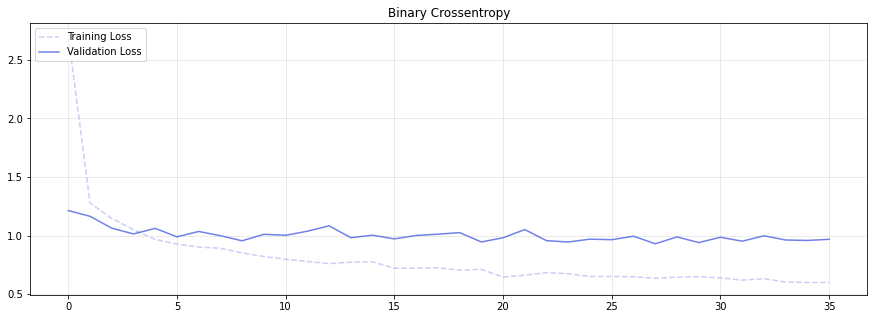

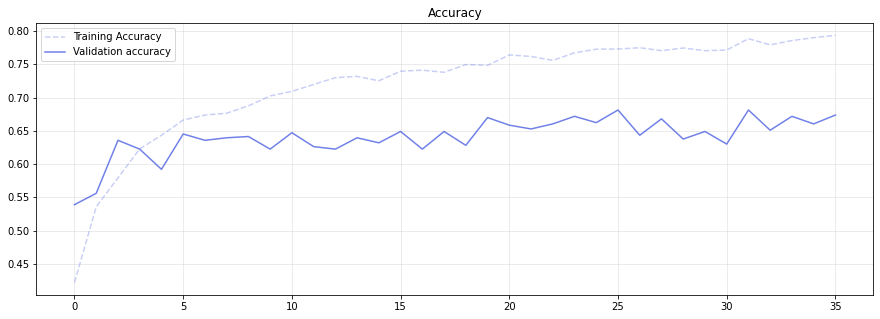

In [19]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [20]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [21]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [22]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [23]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [24]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [25]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

Epoch 1/200
225/225 [==============================] - 32s 135ms/step - loss: 0.9914 - accuracy: 0.6737 - precision_1: 0.7717 - recall_1: 0.5818 - val_loss: 0.8956 - val_accuracy: 0.6603 - val_precision_1: 0.7913 - val_recall_1: 0.5541
Epoch 2/200
225/225 [==============================] - 28s 126ms/step - loss: 0.7949 - accuracy: 0.7299 - precision_1: 0.8100 - recall_1: 0.6479 - val_loss: 0.8468 - val_accuracy: 0.6964 - val_precision_1: 0.7904 - val_recall_1: 0.6224
Epoch 3/200
225/225 [==============================] - 29s 129ms/step - loss: 0.6170 - accuracy: 0.7814 - precision_1: 0.8512 - recall_1: 0.7197 - val_loss: 0.9818 - val_accuracy: 0.6964 - val_precision_1: 0.7738 - val_recall_1: 0.6167
Epoch 4/200
225/225 [==============================] - 28s 126ms/step - loss: 0.5353 - accuracy: 0.8118 - precision_1: 0.8695 - recall_1: 0.7643 - val_loss: 0.7831 - val_accuracy: 0.7533 - val_precision_1: 0.8086 - val_recall_1: 0.6812
Epoch 5/200
225/225 [==============================] - 2

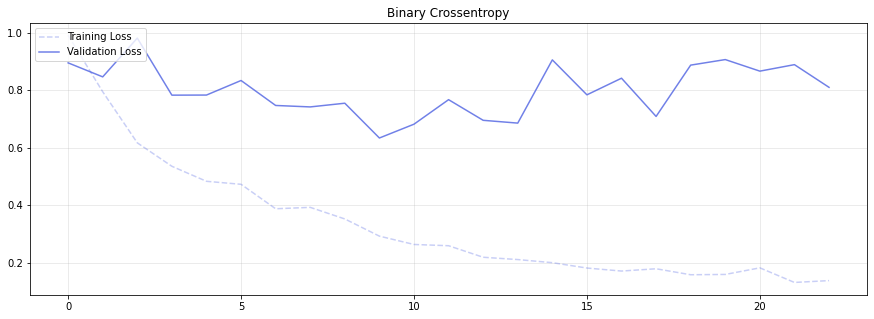

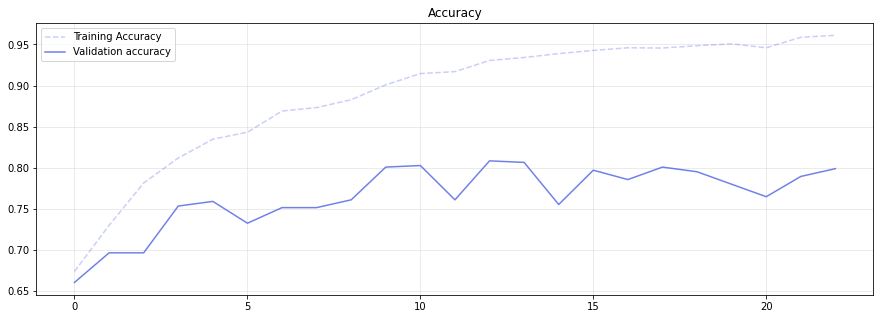

In [26]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [27]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [28]:
tl_model.save('Vgg16/Tuned_v1_1')

In [29]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

12/12 [==============================] - 1s 91ms/step - loss: 1.0945 - accuracy: 0.7729 - precision_1: 0.7929 - recall_1: 0.7424

Test metrics
{'loss': 1.0944558382034302, 'accuracy': 0.7728531956672668, 'precision_1': 0.7928994297981262, 'recall_1': 0.742382287979126}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """


Accuracy: 0.7729
Precision: 0.7806
Recall: 0.7307
F1: 0.7283


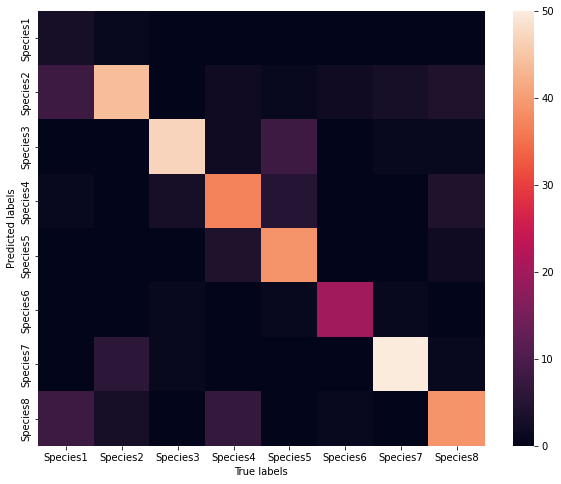

In [30]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()